<a href="https://colab.research.google.com/github/Arijonz/SIMA/blob/main/uts_ml_2201020050.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UTS Machine Learning

> **Nama        : Rio Arijona**

> **NIM         : 2201020050**

> **Prodi       : IF / MLM 1**

> **Mata Kuliah : Machine Learning**

> **Dosen       : Ida Bagus Kresna Sudiatmika, S.Kom., M.T.**


## 0. Setup & Imports

In [9]:
import os, math, json, joblib, itertools, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (7, 5)
os.makedirs("artifacts", exist_ok=True)


## 1. Data Loading / Generation

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls /content/drive/MyDrive/uts_ml_polynomial_project/data


properties.csv


In [11]:
# Ubah path ini bila Anda menggunakan dataset lain
CSV_PATH = "/content/drive/MyDrive/uts_ml_polynomial_project/data/properties.csv"
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError("Dataset tidak ditemukan. Pastikan `/content/drive/MyDrive/uts_ml_polynomial_project/data/properties.csv` tersedia.")

df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
display(df.head())


Shape: (250, 6)


,luas_tanah_m2,luas_bangunan_m2,kamar_tidur,umur_bangunan_tahun,jarak_ke_pusat_kota_km,harga_juta
0,398.28,271.21,5,12.35,17.86,1112.15
1,247.50,350.97,4,23.81,8.50,1288.27
2,436.37,197.94,3,2.54,7.06,926.30
3,363.82,121.70,5,16.66,12.57,705.48
4,92.38,117.57,1,24.06,12.04,209.30


## 2. EDA — Exploratory Data Analysis

,luas_tanah_m2,luas_bangunan_m2,kamar_tidur,umur_bangunan_tahun,jarak_ke_pusat_kota_km,harga_juta
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,273.234560,213.255840,3.144000,14.597680,10.664040,815.425600
std,128.101768,107.088473,1.418206,8.990099,5.468978,360.174965
min,53.310000,32.010000,1.000000,0.040000,1.040000,200.000000
25%,156.062500,117.577500,2.000000,6.965000,5.820000,508.745000
50%,270.340000,218.900000,3.000000,14.800000,10.140000,774.670000
75%,386.667500,305.952500,4.000000,22.300000,15.520000,1134.015000
max,496.570000,399.670000,5.000000,29.960000,19.970000,1678.910000


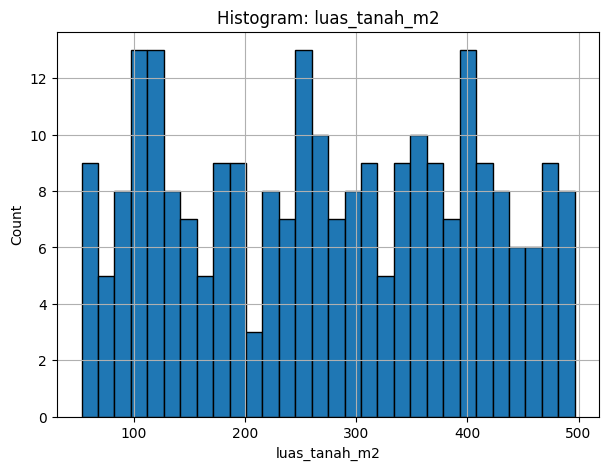

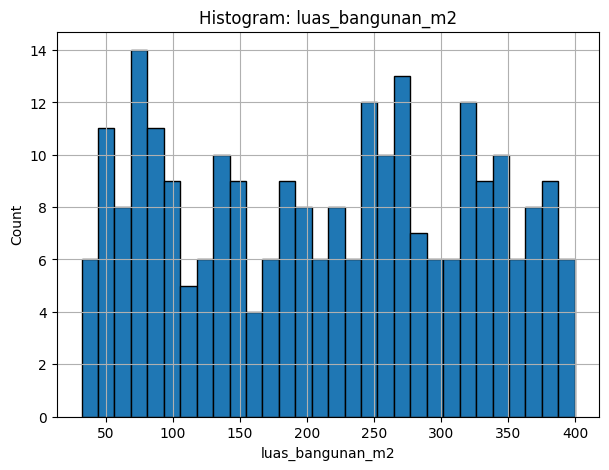

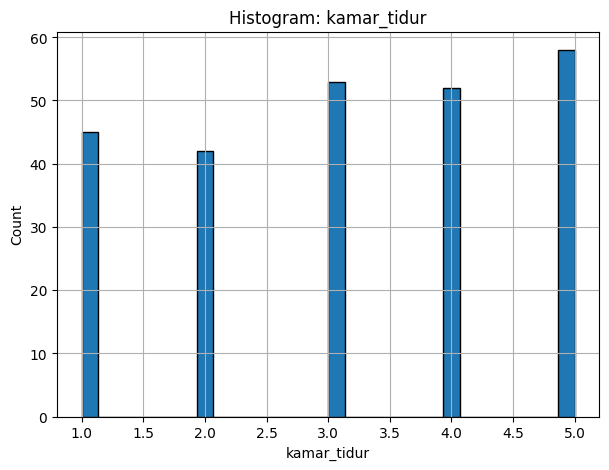

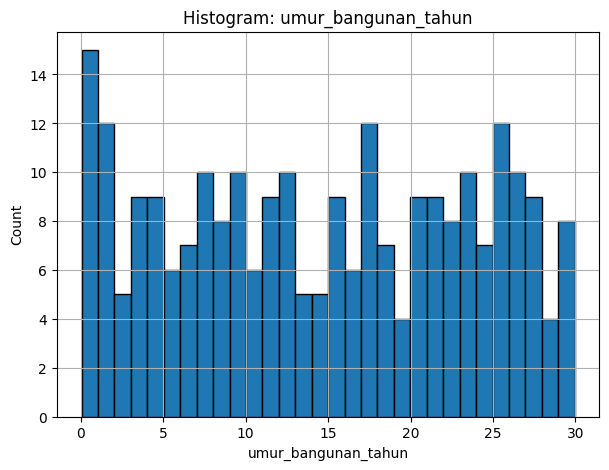

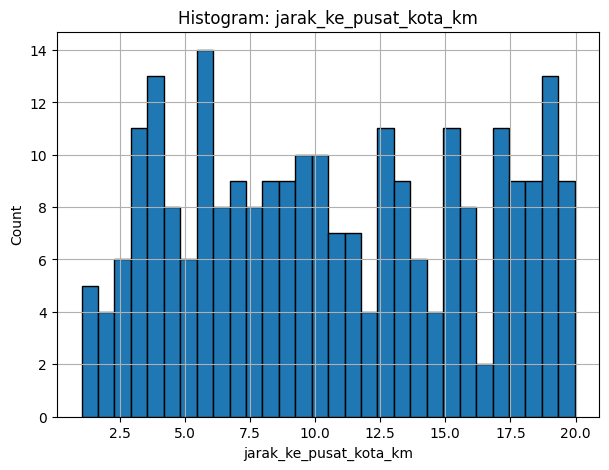

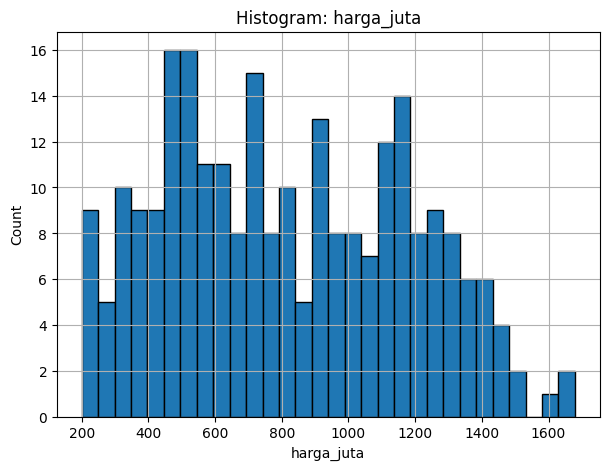

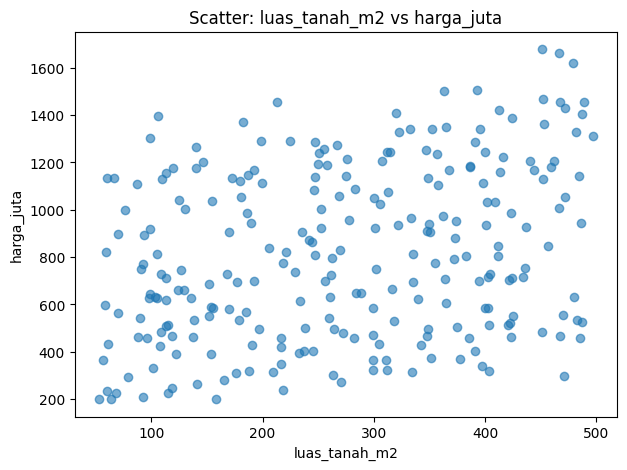

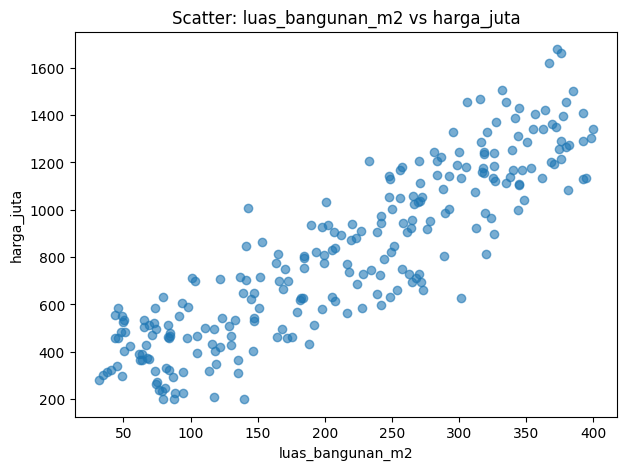

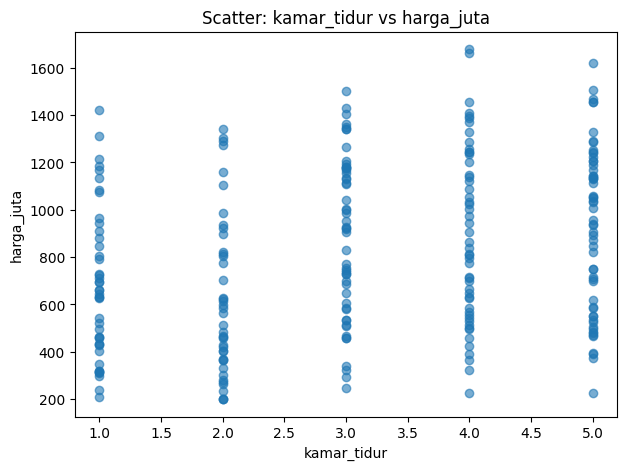

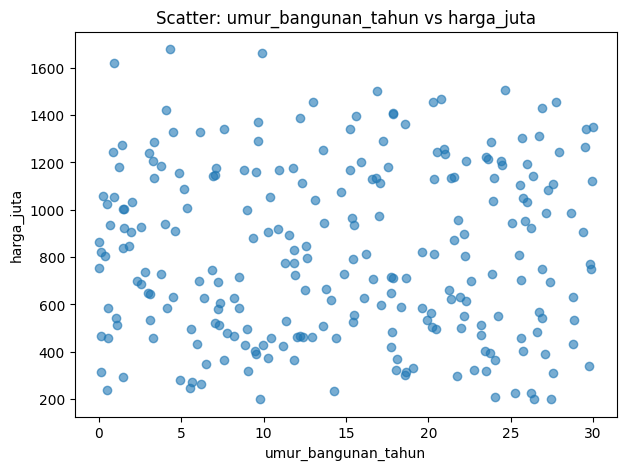

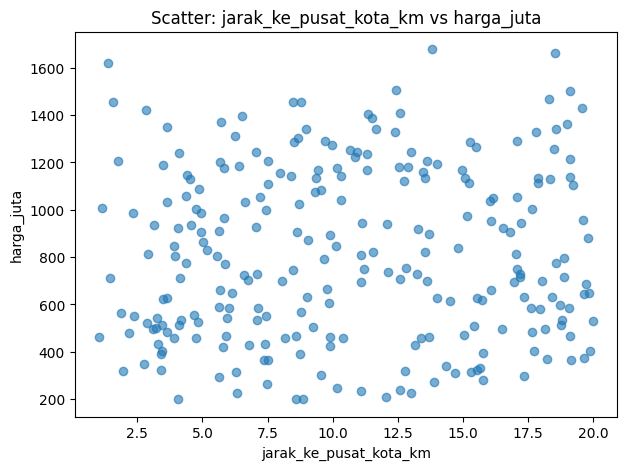

                        luas_tanah_m2  luas_bangunan_m2  kamar_tidur  \
luas_tanah_m2                   1.000             0.006        0.117   
luas_bangunan_m2                0.006             1.000        0.025   
kamar_tidur                     0.117             0.025        1.000   
umur_bangunan_tahun            -0.019             0.092       -0.052   
jarak_ke_pusat_kota_km          0.042             0.108        0.032   
harga_juta                      0.299             0.891        0.289   

                        umur_bangunan_tahun  jarak_ke_pusat_kota_km  \
luas_tanah_m2                        -0.019                   0.042   
luas_bangunan_m2                      0.092                   0.108   
kamar_tidur                          -0.052                   0.032   
umur_bangunan_tahun                   1.000                   0.103   
jarak_ke_pusat_kota_km                0.103                   1.000   
harga_juta                            0.014                   0.050  

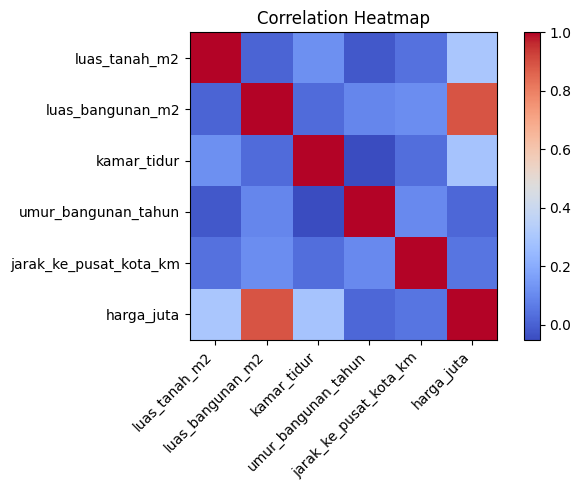

Outliers (simple IQR rule) on harga_juta: 0 rows


In [12]:
# 2A. Statistical summary
display(df.describe(include="all"))

# 2B. Histograms
for col in df.columns:
    plt.figure()
    df[col].hist(bins=30, edgecolor='black')
    plt.title(f"Histogram: {col}")
    plt.xlabel(col); plt.ylabel("Count")
    plt.show()

# 2C. Scatter vs target
target = "harga_juta"
features = [c for c in df.columns if c != target]
for col in features:
    plt.figure()
    plt.scatter(df[col], df[target], alpha=0.6)
    plt.title(f"Scatter: {col} vs {target}")
    plt.xlabel(col); plt.ylabel(target)
    plt.show()

# 2D. Correlation heatmap
corr = df.corr(numeric_only=True)
print(corr.round(3))
plt.figure()
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.title("Correlation Heatmap")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.tight_layout()
plt.show()

# 2E. Outlier check (simple IQR on target)
Q1, Q3 = df[target].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
outliers = df[(df[target] < lower) | (df[target] > upper)]
print(f"Outliers (simple IQR rule) on {target}: {len(outliers)} rows")


## 3. Preprocessing — Train/Test Split + Scaling + Missing Handling

In [13]:
# 70/30 split
X = df.drop(columns=[target])
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

X_train = X_train.fillna(X_train.median(numeric_only=True))
X_test  = X_test.fillna(X_train.median(numeric_only=True))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, "artifacts/scaler.joblib")
print("Scaler saved to artifacts/scaler.joblib")


Scaler saved to artifacts/scaler.joblib


In [14]:
!ls artifacts

scaler.joblib


In [15]:
import joblib
scaler_loaded = joblib.load("artifacts/scaler.joblib")
print(scaler_loaded.mean_)
print(scaler_loaded.scale_)


[266.17108571 216.99302857   3.22857143  15.02834286  10.70514286]
[126.55949629 105.45485314   1.40378497   8.82665024   5.49602327]


## 4. Helper Functions (Metrics, Training, Evaluation Tables)

In [16]:
def regression_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100
    return {"R2": r2, "MSE": mse, "RMSE": rmse, "MAE": mae, "MAPE_%": mape}

def train_poly_model(Xtr, ytr, Xte, yte, degree=1, model_type="linear", alpha=1.0):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    Xtr_poly = poly.fit_transform(Xtr)
    Xte_poly = poly.transform(Xte)

    if model_type == "linear":
        model = LinearRegression()
    elif model_type == "ridge":
        model = Ridge(alpha=alpha, random_state=42)
    elif model_type == "lasso":
        model = Lasso(alpha=alpha, random_state=42, max_iter=10000)
    else:
        raise ValueError("Unknown model_type")

    model.fit(Xtr_poly, ytr)

    ytr_pred = model.predict(Xtr_poly)
    yte_pred = model.predict(Xte_poly)

    train_m = regression_metrics(ytr, ytr_pred)
    test_m  = regression_metrics(yte, yte_pred)
    return model, poly, train_m, test_m

def as_table(rows):
    dfm = pd.DataFrame(rows)
    display(dfm.sort_values(by=["Degree","Model","Alpha"]).reset_index(drop=True))
    return dfm


## 5. Polynomial Features (Degree 1–5) & Linear/Ridge/Lasso

In [19]:
results = []
saved_models = {}

degrees = [1,2,3,4,5]
ridge_alphas = [0.1, 1.0, 10.0]
lasso_alphas = [0.1, 1.0, 10.0]

for deg in degrees:
    # Linear
    model, poly, tr, te = train_poly_model(X_train_scaled, y_train, X_test_scaled, y_test, degree=deg, model_type="linear")
    results.append({"Degree":deg, "Model":"Linear", "Alpha":0, **{f"train_{k}":v for k,v in tr.items()}, **{f"test_{k}":v for k,v in te.items()}})
    saved_models[(deg,"linear",0)] = (model, poly)

    # Ridge
    for a in ridge_alphas:
        model, poly, tr, te = train_poly_model(X_train_scaled, y_train, X_test_scaled, y_test, degree=deg, model_type="ridge", alpha=a)
        results.append({"Degree":deg, "Model":"Ridge", "Alpha":a, **{f"train_{k}":v for k,v in tr.items()}, **{f"test_{k}":v for k,v in te.items()}})
        saved_models[(deg,"ridge",a)] = (model, poly)

    # Lasso
    for a in lasso_alphas:
        model, poly, tr, te = train_poly_model(X_train_scaled, y_train, X_test_scaled, y_test, degree=deg, model_type="lasso", alpha=a)
        results.append({"Degree":deg, "Model":"Lasso", "Alpha":a, **{f"train_{k}":v for k,v in tr.items()}, **{f"test_{k}":v for k,v in te.items()}})
        saved_models[(deg,"lasso",a)] = (model, poly)

results_df = as_table(results)

# Tampilkan jumlah fitur untuk setiap degree (tanpa bias)
for deg in degrees:
    pf = PolynomialFeatures(degree=deg, include_bias=False)
    pf.fit(np.zeros((1, X_train.shape[1])))
    print(f"Degree {deg} -> jumlah fitur: {pf.n_output_features_}")


,Degree,Model,Alpha,train_R2,train_MSE,train_RMSE,train_MAE,train_MAPE_%,test_R2,test_MSE,test_RMSE,test_MAE,test_MAPE_%
0,1,Lasso,0.1,0.938790,7.249949e+03,8.514663e+01,6.688708e+01,1.071042e+01,0.941360,9034.372426,95.049316,79.164854,12.982476
1,1,Lasso,1.0,0.938745,7.255249e+03,8.517775e+01,6.697508e+01,1.073408e+01,0.940379,9185.526958,95.841155,79.968408,13.097827
2,1,Lasso,10.0,0.934271,7.785254e+03,8.823409e+01,6.977000e+01,1.132241e+01,0.926507,11322.674135,106.408055,90.246550,14.524528
3,1,Linear,0.0,0.938791,7.249895e+03,8.514632e+01,6.687730e+01,1.070779e+01,0.941464,9018.276173,94.964605,79.075548,12.969656
4,1,Ridge,0.1,0.938790,7.249935e+03,8.514655e+01,6.688233e+01,1.070944e+01,0.941417,9025.535919,95.002821,79.112183,12.972710
5,1,Ridge,1.0,0.938758,7.253775e+03,8.516910e+01,6.694993e+01,1.073007e+01,0.940967,9094.863975,95.366996,79.439337,12.999928
6,1,Ridge,10.0,0.935850,7.598237e+03,8.716786e+01,6.862993e+01,1.115107e+01,0.934214,10135.281293,100.674134,84.506143,13.599199
7,2,Lasso,0.1,0.949264,6.009417e+03,7.752043e+01,6.088084e+01,9.736837e+00,0.943017,8779.041660,93.696540,77.582154,12.400921
8,2,Lasso,1.0,0.949020,6.038331e+03,7.770670e+01,6.092706e+01,9.837333e+00,0.943176,8754.597682,93.566007,77.796950,12.558840
9,2,Lasso,10.0,0.938979,7.227615e+03,8.501538e+01,6.744181e+01,1.098867e+01,0.929452,10868.992692,104.254461,88.065823,14.228764


Degree 1 -> jumlah fitur: 5
Degree 2 -> jumlah fitur: 20
Degree 3 -> jumlah fitur: 55
Degree 4 -> jumlah fitur: 125
Degree 5 -> jumlah fitur: 251


## 6. Learning Curves (Over/Underfitting Analysis)

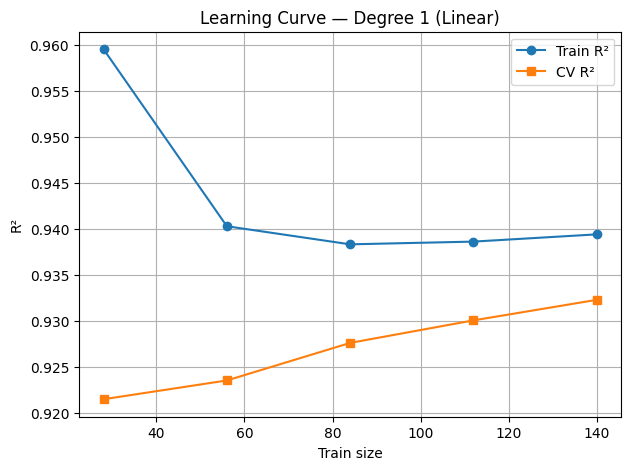

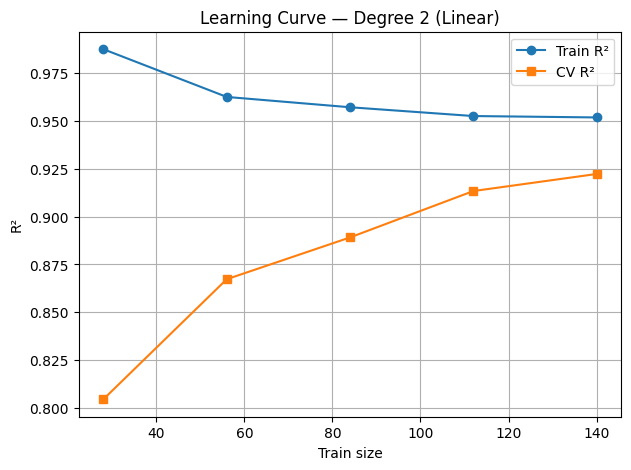

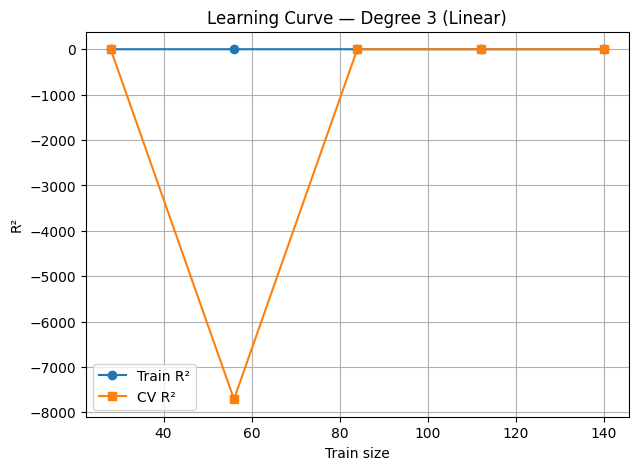

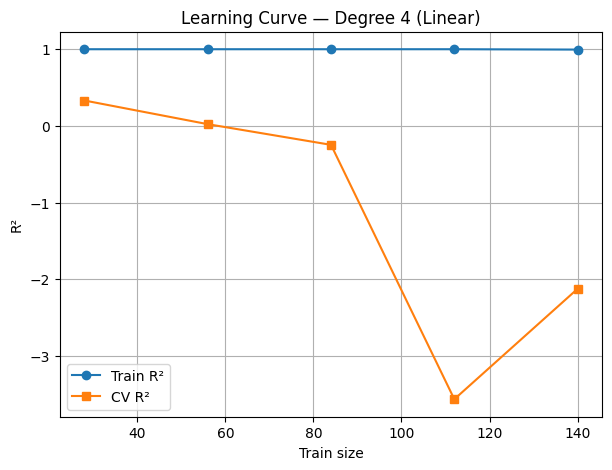

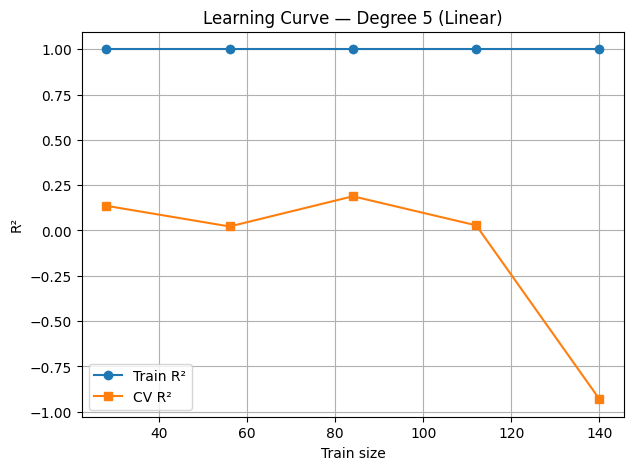

In [20]:
def plot_learning_curve_for(degree):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    Xtr_poly = poly.fit_transform(X_train_scaled)
    est = LinearRegression()
    train_sizes, train_scores, test_scores = learning_curve(est, Xtr_poly, y_train, cv=5, scoring='r2', train_sizes=np.linspace(0.2, 1.0, 5), random_state=42)
    plt.figure()
    plt.plot(train_sizes, train_scores.mean(axis=1), marker='o', label='Train R²')
    plt.plot(train_sizes, test_scores.mean(axis=1), marker='s', label='CV R²')
    plt.title(f"Learning Curve — Degree {degree} (Linear)")
    plt.xlabel("Train size"); plt.ylabel("R²"); plt.legend(); plt.grid(True); plt.show()

for deg in [1,2,3,4,5]:
    plot_learning_curve_for(deg)


## 7. Visualization — Predicted vs Actual, Residuals, Polynomial Curve (2 fitur) & R² vs Degree

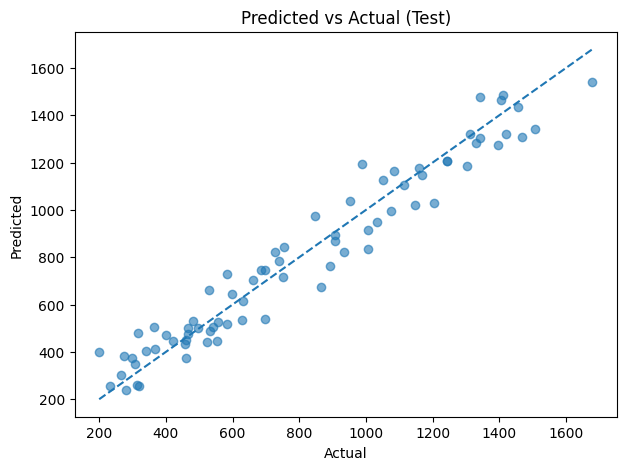

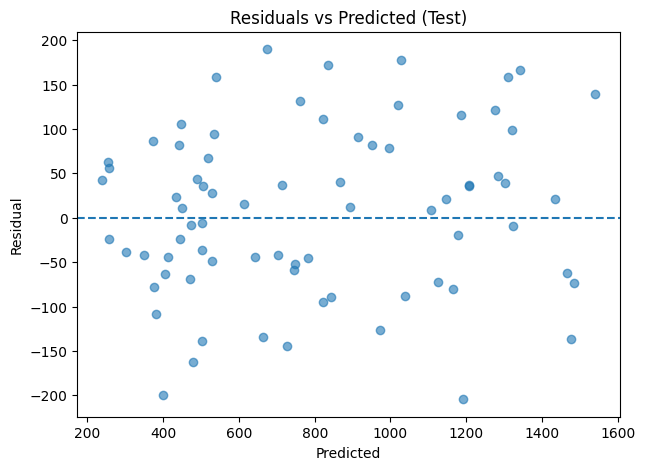

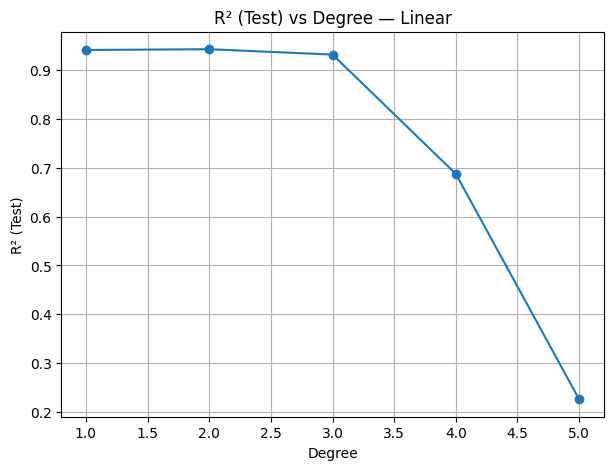

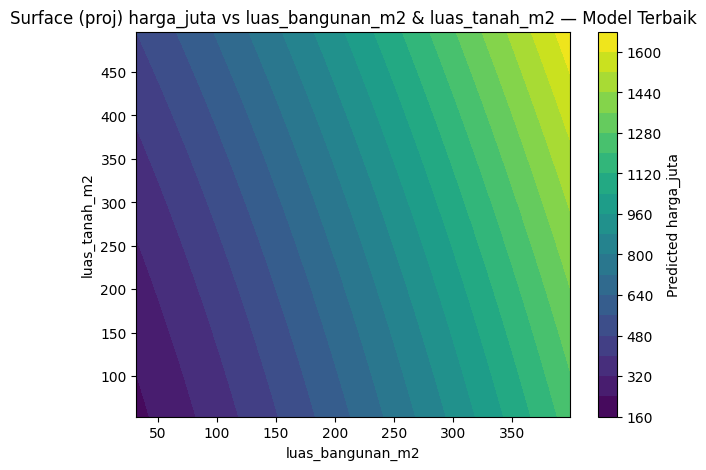

In [21]:
# Ambil salah satu model terbaik berdasarkan test_R2
best_row = results_df.sort_values(by="test_R2", ascending=False).iloc[0]
key = (int(best_row["Degree"]), best_row["Model"].lower(), float(best_row["Alpha"]))
best_model, best_poly = saved_models[key]

Xte_poly = best_poly.transform(X_test_scaled)
y_pred = best_model.predict(Xte_poly)

# Predicted vs Actual
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--')
plt.title("Predicted vs Actual (Test)")
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.figure()
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, linestyle='--')
plt.title("Residuals vs Predicted (Test)")
plt.xlabel("Predicted"); plt.ylabel("Residual")
plt.show()

# R2 vs Degree (pakai Linear model)
deg_r2 = results_df[results_df["Model"]=="Linear"].groupby("Degree")["test_R2"].max()
plt.figure()
plt.plot(deg_r2.index, deg_r2.values, marker='o')
plt.title("R² (Test) vs Degree — Linear")
plt.xlabel("Degree"); plt.ylabel("R² (Test)")
plt.grid(True)
plt.show()

# Polynomial curve
f1, f2 = "luas_bangunan_m2", "luas_tanah_m2"
med = X_train.median(numeric_only=True)
grid1 = np.linspace(X[f1].min(), X[f1].max(), 80)
grid2 = np.linspace(X[f2].min(), X[f2].max(), 80)

# 3D-like via mesh projection to 2D heatmap of predicted price
g1, g2 = np.meshgrid(grid1, grid2)

# Buat satu baris dari median untuk seluruh kolom fitur (urut sesuai X.columns)
base_row = med.reindex(X.columns).to_frame().T

Xgrid = pd.concat([base_row] * g1.size, ignore_index=True)

Xgrid.loc[:, f1] = g1.ravel()
Xgrid.loc[:, f2] = g2.ravel()

# Transform dan prediksi
Xgrid_scaled = scaler.transform(Xgrid)
Xgrid_poly   = best_poly.transform(Xgrid_scaled)
pred_grid    = best_model.predict(Xgrid_poly).reshape(g1.shape)

# Plot heatmap kontur
plt.figure()
plt.contourf(g1, g2, pred_grid, levels=20)
plt.colorbar(label="Predicted harga_juta")
plt.xlabel(f1); plt.ylabel(f2)
plt.title(f"Surface (proj) harga_juta vs {f1} & {f2} — Model Terbaik")
plt.show()


## 8. Regularization Analysis — Ridge vs Lasso (α grid)

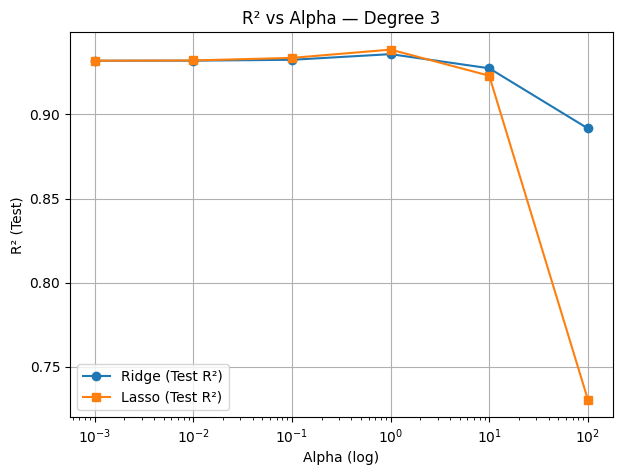

Alpha optimal (ridge,l ecolass o) ≈ 1 1


In [22]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
deg = 3  # contoh fokus degree 3

r2_ridge, r2_lasso = [], []
for a in alphas:
    m, p, tr, te = train_poly_model(X_train_scaled, y_train, X_test_scaled, y_test, degree=deg, model_type="ridge", alpha=a)
    r2_ridge.append(te["R2"])
    m, p, tr, te = train_poly_model(X_train_scaled, y_train, X_test_scaled, y_test, degree=deg, model_type="lasso", alpha=a)
    r2_lasso.append(te["R2"])

plt.figure()
plt.semilogx(alphas, r2_ridge, marker='o', label="Ridge (Test R²)")
plt.semilogx(alphas, r2_lasso, marker='s', label="Lasso (Test R²)")
plt.title("R² vs Alpha — Degree 3")
plt.xlabel("Alpha (log)"); plt.ylabel("R² (Test)"); plt.legend(); plt.grid(True)
plt.show()

best_ridge_alpha = alphas[int(np.argmax(r2_ridge))]
best_lasso_alpha = alphas[int(np.argmax(r2_lasso))]
print("Alpha optimal (ridge,l ecolass o) ≈", best_ridge_alpha, best_lasso_alpha)


## 9. Feature Importance (Koefisien) & Eliminasi Fitur oleh Lasso

,0
luas_bangunan_m2,315.396895
luas_tanah_m2,93.507599
kamar_tidur,71.091160
luas_bangunan_m2^2,27.302641
kamar_tidur^2,-14.550182
jarak_ke_pusat_kota_km,-13.324967
umur_bangunan_tahun,-13.073155
luas_tanah_m2 luas_bangunan_m2,12.453421
luas_bangunan_m2 kamar_tidur,9.484631
luas_tanah_m2 kamar_tidur,-7.682454


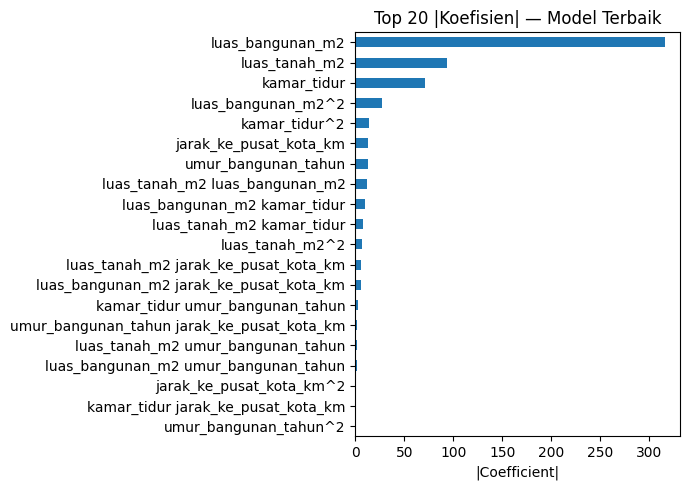

Fitur yang dieliminasi oleh Lasso (alpha=1): 10
['luas_tanah_m2 kamar_tidur' 'kamar_tidur umur_bangunan_tahun'
 'luas_tanah_m2 kamar_tidur^2' 'luas_tanah_m2 umur_bangunan_tahun^2'
 'luas_tanah_m2 umur_bangunan_tahun jarak_ke_pusat_kota_km'
 'luas_bangunan_m2^2 umur_bangunan_tahun'
 'kamar_tidur^2 umur_bangunan_tahun'
 'kamar_tidur umur_bangunan_tahun jarak_ke_pusat_kota_km'
 'kamar_tidur jarak_ke_pusat_kota_km^2'
 'umur_bangunan_tahun jarak_ke_pusat_kota_km^2']


In [23]:
def feature_names_after_poly(feature_names, degree):
    pf = PolynomialFeatures(degree=degree, include_bias=False)
    pf.fit(np.zeros((1,len(feature_names))))
    return pf.get_feature_names_out(feature_names)

# Ambil koefisien dari model terbaik
feature_names = list(X.columns)
names_poly = feature_names_after_poly(feature_names, int(best_row["Degree"]))
coefs = pd.Series(best_model.coef_, index=names_poly).sort_values(key=np.abs, ascending=False)
display(coefs.head(20))

# Bar plot top 20 absolute coefficients
top = coefs.head(20)
plt.figure()
top_abs = top.abs()
top_abs.sort_values(ascending=True).plot(kind='barh')
plt.title("Top 20 |Koefisien| — Model Terbaik")
plt.xlabel("|Coefficient|")
plt.tight_layout(); plt.show()

# Lasso elimination demo (degree=3)
lasso = Lasso(alpha=best_lasso_alpha, random_state=42, max_iter=10000)
pf = PolynomialFeatures(degree=3, include_bias=False)
Xtr_poly = pf.fit_transform(X_train_scaled)
lasso.fit(Xtr_poly, y_train)
names = pf.get_feature_names_out(feature_names)
zeros = (lasso.coef_ == 0)
eliminated = np.array(names)[zeros]
print(f"Fitur yang dieliminasi oleh Lasso (alpha={best_lasso_alpha}): {len(eliminated)}")
print(eliminated[:20])


## 10. Model Selection via Cross-Validation (K-Fold) & Penyimpanan Model Terbaik

In [25]:
def cv_score_for(deg, model_kind, alpha=0.0, k=5):
    pf = PolynomialFeatures(degree=deg, include_bias=False)
    Xtr_poly = pf.fit_transform(X_train_scaled)

    if model_kind == "linear":
        est = LinearRegression()
    elif model_kind == "ridge":
        est = Ridge(alpha=alpha, random_state=42)
    elif model_kind == "lasso":
        est = Lasso(alpha=alpha, random_state=42, max_iter=10000)
    else:
        raise ValueError

    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = cross_val_score(est, Xtr_poly, y_train, cv=kf, scoring='r2')
    return scores.mean(), scores.std()

# Search best by highest Test R², then lowest RMSE as tiebreaker
results_df["rank_key"] = list(zip(-results_df["test_R2"], results_df["test_RMSE"]))
best_row = results_df.sort_values(by=["rank_key"]).iloc[0]
key = (int(best_row["Degree"]), best_row["Model"].lower(), float(best_row["Alpha"]))
best_model, best_poly = saved_models[key]

# CV score for the chosen
cv_mean, cv_std = cv_score_for(int(best_row["Degree"]), best_row["Model"].lower(), float(best_row["Alpha"]) if best_row["Model"]!="Linear" else 0.0, k=5)

print("Best by Test performance:")
display(best_row)
print(f"CV mean R² (k=5): {cv_mean:.4f} ± {cv_std:.4f}")

# Save best model & polynomial features
joblib.dump(best_model, "artifacts/best_model.joblib")
joblib.dump(best_poly, "artifacts/best_poly.joblib")
print("Saved best_model.joblib and best_poly.joblib in artifacts/")


Best by Test performance:


,12
Degree,2
Model,Lasso
Alpha,1.0
train_R2,0.94902
train_MSE,6038.330532
train_RMSE,77.706696
train_MAE,60.927064
train_MAPE_%,9.837333
test_R2,0.943176
test_MSE,8754.597682


CV mean R² (k=5): 0.9209 ± 0.0250
Saved best_model.joblib and best_poly.joblib in artifacts/


## 11. Final Prediction Function + Confidence Interval (Bootstrap)

In [26]:
def predict_with_ci(model, poly, scaler, X_df, n_boot=300, alpha=0.05, random_state=42):
    rng = np.random.default_rng(random_state)
    Xs = scaler.transform(X_df)
    Xp = poly.transform(Xs)
    preds = model.predict(Xp)

    # simple bootstrap of residuals from train set
    # fit residuals
    Xtr_poly = poly.transform(X_train_scaled)
    res = y_train.values - model.predict(Xtr_poly)
    res_sample = rng.choice(res, size=(n_boot, len(X_df)), replace=True)
    boot = preds + res_sample
    lo = np.percentile(boot, 100*alpha/2, axis=0)
    hi = np.percentile(boot, 100*(1-alpha/2), axis=0)
    return preds, lo, hi

# Test with 5 unseen samples
sample_new = pd.DataFrame({
    "luas_tanah_m2":[80, 150, 220, 300, 450],
    "luas_bangunan_m2":[60, 120, 180, 250, 380],
    "kamar_tidur":[2,3,3,4,5],
    "umur_bangunan_tahun":[5,10,8,15,3],
    "jarak_ke_pusat_kota_km":[4,8,10,6,2],
})
preds, lo, hi = predict_with_ci(best_model, best_poly, joblib.load("artifacts/scaler.joblib"), sample_new)

result_pred = sample_new.copy()
result_pred["pred_harga_juta"] = preds
result_pred["ci_low"] = lo
result_pred["ci_high"] = hi
display(result_pred.round(2))

# Simpan tabel prediksi
result_pred.to_csv("artifacts/sample_predictions.csv", index=False)
print("Saved artifacts/sample_predictions.csv")


,luas_tanah_m2,luas_bangunan_m2,kamar_tidur,umur_bangunan_tahun,jarak_ke_pusat_kota_km,pred_harga_juta,ci_low,ci_high
0,80,60,2,5,4,239.75,59.39,392.63
1,150,120,3,10,8,464.91,307.69,606.45
2,220,180,3,8,10,664.68,486.72,801.56
3,300,250,4,15,6,981.31,817.30,1121.18
4,450,380,5,3,2,1665.63,1495.09,1805.49


Saved artifacts/sample_predictions.csv


## 12. BONUS — Polynomial Regression dari Nol (Gradient Descent)

In [ ]:
class PolyRegScratch:
    def __init__(self, degree=2, lr=1e-3, n_iter=10000, reg=None, alpha=0.0):
        self.degree = degree
        self.lr = lr
        self.n_iter = n_iter
        self.reg = reg  # None | "ridge" | "lasso"
        self.alpha = alpha

    def _poly(self, X):
        pf = PolynomialFeatures(self.degree, include_bias=True)
        return pf.fit_transform(X)

    def fit(self, X, y):
        Xp = self._poly(X)
        n, d = Xp.shape
        self.w = np.zeros(d)
        y = y.astype(float)

        for _ in range(self.n_iter):
            yhat = Xp @ self.w
            grad = (2/n) * (Xp.T @ (yhat - y))
            # simple regularization
            if self.reg == "ridge":
                grad += 2 * self.alpha * self.w
            elif self.reg == "lasso":
                grad += self.alpha * np.sign(self.w)

            self.w -= self.lr * grad
        self.d_ = d
        return self

    def predict(self, X):
        Xp = self._poly(X)
        return Xp @ self.w

# Train & compare (degree=2) on scaled data
model_scratch = PolyRegScratch(degree=2, lr=5e-4, n_iter=4000, reg="ridge", alpha=1e-3)
model_scratch.fit(X_train_scaled, y_train.values)
y_pred_scratch = model_scratch.predict(X_test_scaled)
print("Scratch model (deg=2, ridge-like) test R²:", r2_score(y_test, y_pred_scratch))


Scratch model (deg=2, ridge-like) test R²: 0.8217380002282979


---
## 13. Ringkasan & Insight Otomatis
Sel ini membuat ringkasan singkat untuk membantu penyusunan laporan.

In [ ]:
# Simple summary based on results_df
top = results_df.sort_values(by="test_R2", ascending=False).head(5)[["Degree","Model","Alpha","test_R2","test_RMSE","test_MAPE_%"]]
print("Top-5 Model (berdasarkan R² Test tertinggi):")
display(top)

best = results_df.sort_values(by=["rank_key"]).iloc[0]
print("\nModel Terbaik (berdasarkan R² Test tinggi & RMSE rendah):")
display(best[["Degree","Model","Alpha","test_R2","test_RMSE","test_MAPE_%"]])



Top-5 Model (berdasarkan R² Test tertinggi):


,Degree,Model,Alpha,test_R2,test_RMSE,test_MAPE_%
12,2,Lasso,1.0,0.943176,93.566007,12.558840
11,2,Lasso,0.1,0.943017,93.696540,12.400921
7,2,Linear,0.0,0.942959,93.744045,12.386513
8,2,Ridge,0.1,0.942924,93.773120,12.397306
9,2,Ridge,1.0,0.942567,94.065872,12.500246



Model Terbaik (berdasarkan R² Test tinggi & RMSE rendah):


,12
Degree,2
Model,Lasso
Alpha,1.0
test_R2,0.943176
test_RMSE,93.566007
test_MAPE_%,12.55884


In [32]:
import pypandoc

input_path = "/content/drive/MyDrive/uts_ml_polynomial_project/report.md"
output_path = "/content/drive/MyDrive/uts_ml_polynomial_project/report.docx"

pypandoc.convert_text(
    open(input_path, "r", encoding="utf-8").read(),
    'docx',
    format='md',
    outputfile=output_path,
    extra_args=['--standalone']
)

print("report.docx berhasil dibuat di:", output_path)


report.docx berhasil dibuat di: /content/drive/MyDrive/uts_ml_polynomial_project/report.docx
